In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import networkx as nx
import collections
import math
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import binascii, struct
from datetime import datetime
import socket, struct
import string
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Read files

In [2]:
g = glob.glob('D:/swat/*.csv')

In [3]:
dataframes = []

for filename in g[490:540]:
    print("loading file: {}".format(filename))
    d = pd.read_csv(filename,error_bad_lines = False, sep=",")
    dataframes.append(d[d['Modbus_Value']!= 'Number of Elements: 1'][['date','time','orig','type','i/f_name','i/f_dir','src','dst','proto','appi_name','proxy_src_ip','Modbus_Function_Code','Modbus_Function_Description','Modbus_Transaction_ID','SCADA_Tag','Modbus_Value','service','s_port','Tag']])

loading file: D:/swat\2015-12-29_190411_104.log.part01_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part02_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part03_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part04_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part05_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part06_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part07_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part08_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part09_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part10_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part11_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part12_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part13_sorted.csv
loading file: D:/swat\2015-12-29_190411_104.log.part14_sorted.csv
loading file: D:/swat\2015-12-30_001940_105.log.part01_sorted.csv
loading fi

In [4]:
#combine those dataframes
df = pd.concat(dataframes,ignore_index=True)

In [5]:
## del dataframes to save memory
del dataframes

In [6]:
#what does the df look like
df.head()

,date,time,orig,type,i/f_name,i/f_dir,src,dst,proto,appi_name,proxy_src_ip,Modbus_Function_Code,Modbus_Function_Description,Modbus_Transaction_ID,SCADA_Tag,Modbus_Value,service,s_port,Tag
0,29Dec2015,13:39:41,192.168.1.48,log,eth1,outbound,192.168.1.30,192.168.1.40,tcp,CIP_read_tag_service,192.168.1.30,76.0,Read Tag Service - Response,7644.0,HMI_LIT401,0x03 0xa7 0x66 0x44; 0x00 0x00 0x00 0x00; 0x00...,44818.0,52544.0,0
1,29Dec2015,13:39:41,192.168.1.48,log,eth1,outbound,192.168.1.60,192.168.1.10,tcp,CIP_read_tag_service,192.168.1.60,76.0,Read Tag Service - Response,13765.0,HMI_LIT101,0x44 0x5e 0x02 0x44; 0x00 0x00 0x00 0x00; 0x00...,44818.0,53260.0,0
2,29Dec2015,13:39:41,192.168.1.48,log,eth1,outbound,192.168.1.10,192.168.1.20,tcp,CIP_read_tag_service,192.168.1.10,76.0,Read Tag Service - Response,62639.0,HMI_FIT201,0xca 0x8b 0x1c 0x40; 0x00 0x00 0x00 0x00; 0x00...,44818.0,54592.0,0
3,29Dec2015,13:39:41,192.168.1.48,log,eth1,outbound,192.168.1.60,192.168.1.20,tcp,CIP_read_tag_service,192.168.1.60,76.0,Read Tag Service - Response,57718.0,HMI_AIT202,0xfe 0x9f 0x06 0x41; 0x00 0x00 0x00 0x00; 0x00...,44818.0,53250.0,0
4,29Dec2015,13:39:41,192.168.1.48,log,eth1,outbound,192.168.1.20,192.168.1.30,tcp,CIP_read_tag_service,192.168.1.20,76.0,Read Tag Service - Response,39387.0,HMI_LIT301,0x9f 0xf8 0x6e 0x44; 0x00 0x00 0x00 0x00; 0x00...,44818.0,53326.0,0


In [7]:
#Since the date format is not the same. (i.e some are DD-MMM-YY, some are DDMMMYYYY), we make the date format be the same.
def changeformat(s):
    if "-" in s:
        s = s.replace("-", "", 1)
        s = s.replace("-", "20", 1)
    return s
df['date'] = list(map(changeformat,df['date']))

In [8]:
# change "dec" into 12 and "Jan" into 1 so that the following function can work.
def montoint(s):
    if s == "Dec":
        t = 12
    if s == "Jan":
        t = 1
    return t


#Create a new column called sec. the value means how many seconds are there since 21-12-2015, 22:17:56. 
def timetosec(a,b):
    s = datetime(2015,12,21,22,17,56)
    [year, month, day] =[int(a[5:9]),montoint(a[2:5]),int(a[0:2])]
    [hours, minutes, seconds] = [int(x) for x in b.split(':')]
    now = datetime(year,month,day,hours,minutes,seconds)
    diff_seconds = int((now-s).total_seconds())
    return diff_seconds

df['sec'] = list(map(timetosec,df['date'],df['time']))

In [9]:
df = df.drop(["date", "time"], axis=1) ##save memory

In [11]:
## remove all nan values.
df = df[df['i/f_dir']=='outbound']
df = df[df['src'].notna()]
df = df[df['dst'].notna()]
df = df[df['orig'].notna()]
df = df[df['proxy_src_ip'].notna()]
df = df[df['Modbus_Function_Code'].notna()]
df = df[df['Modbus_Function_Description'].notna()]
df = df[df['Modbus_Transaction_ID'].notna()]
df = df[df['SCADA_Tag'].notna()]
df = df[df['appi_name'].notna()]
df = df[df['proto'].notna()]
df = df[df['type'].notna()]
df = df[df['Modbus_Value'].notna()]




In [12]:
df = df.drop(['i/f_dir','i/f_name'],axis=1) ##save memory since all the values in this column are the same.

In [13]:
df.index = range(len(df.index))## reindex the df.

In [14]:
#convert IP address into numeric values so that the random forest model can learn the values.

def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

df['src'] = list(map(ip2long,df['src']))
df['dst'] = list(map(ip2long,df['dst']))
df['orig'] = list(map(ip2long,df['orig']))
df['proxy_src_ip'] = list(map(ip2long,df['proxy_src_ip']))



,orig,type,src,dst,proto,appi_name,proxy_src_ip,Modbus_Function_Code,Modbus_Function_Description,Modbus_Transaction_ID,SCADA_Tag,Modbus_Value,service,s_port,Tag,sec
0,3232235824,log,3232235806,3232235816,tcp,CIP_read_tag_service,3232235806,76.0,Read Tag Service - Response,7644.0,HMI_LIT401,0x03 0xa7 0x66 0x44; 0x00 0x00 0x00 0x00; 0x00...,44818.0,52544.0,0,660105
1,3232235824,log,3232235836,3232235786,tcp,CIP_read_tag_service,3232235836,76.0,Read Tag Service - Response,13765.0,HMI_LIT101,0x44 0x5e 0x02 0x44; 0x00 0x00 0x00 0x00; 0x00...,44818.0,53260.0,0,660105
2,3232235824,log,3232235786,3232235796,tcp,CIP_read_tag_service,3232235786,76.0,Read Tag Service - Response,62639.0,HMI_FIT201,0xca 0x8b 0x1c 0x40; 0x00 0x00 0x00 0x00; 0x00...,44818.0,54592.0,0,660105
3,3232235824,log,3232235836,3232235796,tcp,CIP_read_tag_service,3232235836,76.0,Read Tag Service - Response,57718.0,HMI_AIT202,0xfe 0x9f 0x06 0x41; 0x00 0x00 0x00 0x00; 0x00...,44818.0,53250.0,0,660105
4,3232235824,log,3232235796,3232235806,tcp,CIP_read_tag_service,3232235796,76.0,Read Tag Service - Response,39387.0,HMI_LIT301,0x9f 0xf8 0x6e 0x44; 0x00 0x00 0x00 0x00; 0x00...,44818.0,53326.0,0,660105


In [15]:
#factorize the categorical features. 
df['SCADA_Tag'] = pd.factorize(df.SCADA_Tag)[0]
df['Modbus_Function_Description'] = pd.factorize(df.Modbus_Function_Description)[0]
df['appi_name'] = pd.factorize(df.appi_name)[0]
df['proto'] = pd.factorize(df.proto)[0]
df['type'] = pd.factorize(df.type)[0]

In [16]:
#convert hex into decimal values, and split the modbus values by ";".
def modbus_conversion(value):
    lst = []
    for i in range(len(value.split(";"))):
        x = value.split(";")[i]
        if " " in x:
            x = x.replace(" ","")
        if '0x' in x:
            x = x.replace("0x","")
            if all(c in string.hexdigits for c in x):
                x = struct.unpack('<f',binascii.unhexlify(x))[0]
            else:
                x = 0
        x = float(x)
        lst.append(x)
    return lst

df['Modbus_Value'] = list(map(modbus_conversion,df['Modbus_Value']))

In [ ]:
df.head()

In [17]:
#create 11 new columns to put the splitted modbus value. The length of modbus value is 9 or 11. if the length is 9, we set the 
# value of "modbus_9" and "modbus_10" as 0.
df['Modbus_0'] = list(map(lambda x : x[0],df['Modbus_Value']))
df['Modbus_1'] = list(map(lambda x : x[1],df['Modbus_Value']))
df['Modbus_2'] = list(map(lambda x : x[2],df['Modbus_Value']))
df['Modbus_3'] = list(map(lambda x : x[3],df['Modbus_Value']))
df['Modbus_4'] = list(map(lambda x : x[4],df['Modbus_Value']))
df['Modbus_5'] = list(map(lambda x : x[5],df['Modbus_Value']))
df['Modbus_6'] = list(map(lambda x : x[6],df['Modbus_Value']))
df['Modbus_7'] = list(map(lambda x : x[7],df['Modbus_Value']))
df['Modbus_8'] = list(map(lambda x : x[8],df['Modbus_Value']))

def mod9(mod):
    if len(mod)>9:
        return mod[9]
    else:
        return 0
    
def mod10(mod):
    if len(mod)>9:
        return mod[10]
    else:
        return 0

df['Modbus_9'] = list(map(mod9,df['Modbus_Value']))
df['Modbus_10'] = list(map(mod10,df['Modbus_Value']))

In [18]:
df = df.drop('Modbus_Value',axis=1) #save memory

In [19]:
#standardize all numerical values
df[['src','dst','orig','proxy_src_ip','Modbus_Function_Code','Modbus_Transaction_ID','s_port','service','Modbus_0','Modbus_1','Modbus_2','Modbus_3','Modbus_4','Modbus_5','Modbus_6','Modbus_7','Modbus_8','Modbus_9','Modbus_10']]= StandardScaler().fit_transform(df[['src','dst','orig','proxy_src_ip','Modbus_Function_Code','Modbus_Transaction_ID','s_port','service','Modbus_0','Modbus_1','Modbus_2','Modbus_3','Modbus_4','Modbus_5','Modbus_6','Modbus_7','Modbus_8','Modbus_9','Modbus_10']])

C:\Users\seeml\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\seeml\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
df.head() #what does df look like after pre-processing

,orig,type,src,dst,proto,appi_name,proxy_src_ip,Modbus_Function_Code,Modbus_Function_Description,Modbus_Transaction_ID,...,Modbus_1,Modbus_2,Modbus_3,Modbus_4,Modbus_5,Modbus_6,Modbus_7,Modbus_8,Modbus_9,Modbus_10
0,0.0,0,-0.210568,1.664708,0,0,-0.210568,0.0,0,-1.327985,...,0.0,0.0,0.755749,1.022868,1.141776,0.874877,-0.599166,1.175555,-0.492220,-0.493917
1,0.0,0,1.211750,-1.330415,0,0,1.211750,0.0,0,-1.004442,...,0.0,0.0,0.929126,0.590794,0.302460,0.874877,-0.599166,0.186529,-0.492220,-0.493917
2,0.0,0,-1.158779,-0.332040,0,0,-1.158779,0.0,0,1.578935,...,0.0,0.0,-1.145332,-1.133181,-1.096400,-1.152628,1.606104,-1.094262,2.027842,2.024630
3,0.0,0,1.211750,-0.332040,0,0,1.211750,0.0,0,1.318821,...,0.0,0.0,-1.134062,-1.122272,-1.076956,-1.128298,-0.590040,-1.078448,-0.492220,-0.493917
4,0.0,0,-0.684674,0.666334,0,0,-0.684674,0.0,0,0.349883,...,0.0,0.0,0.929126,1.022868,1.141776,0.874877,-0.599166,1.257596,-0.492220,-0.493917


In [21]:
#split the data into train and test.
y = df['Tag']

z = df['sec']

df = df.drop('Tag',axis=1)

df = df.drop('sec',axis=1)

x = df.values

X_train, X_test, y_train, y_test,z_train,z_test=train_test_split(x,y,z,test_size = 0.25)

## random forest classifier

In [22]:
regressor = RandomForestClassifier(n_estimators=10, random_state=0)  
regressor.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
#Predictions
y_pred = regressor.predict(X_test) 

In [24]:
#confusion matrix
matrix = confusion_matrix(y_pred,y_test)
matrix

array([[2901101,   70801],
       [  50817,   79478]], dtype=int64)

In [25]:
# normal: negative , attack:postive

#false negative rate
fnr = matrix[0][1]/(matrix[1][1]+matrix[0][1])
#false positive rate
fpr = matrix[1][0]/(matrix[0][0]+matrix[1][0])
print("false negative rate: %f"%fnr)
print("false positive rate: %f"%fpr)

false negative rate: 0.471130
false positive rate: 0.017215


## random forest regressor

In [27]:
#to check whether the random forest learn the time
model = RandomForestRegressor(random_state=0, n_estimators=10)
model.fit(X_train, z_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [28]:
y_test =y_test.values.tolist()
attack_ind = []
for i in range(len(y_test)):
    if y_test[i] == 1:
        attack_ind.append(i)


In [29]:
z_test = z_test.values.tolist()

In [31]:
def cl(a,b):
    l=[]
    for i in range(len(b)):
        l.append(a[i])
    return l

In [32]:
x_rtest = cl(X_test,attack_ind)
z_rtest = cl(z_test,attack_ind)

In [33]:
# predictions
pred = model.predict(x_rtest)

res = pred - z_rtest

res = np.array(res)


#if the residual is within 60 secs, we say that it is a good prediction.
c = 0
for i in range(len(res)):
    if abs(res[i])<=60:
        c += 1


In [34]:
# accuracy that residuals are within 60 secs.
print(c/len(res))

0.31684400348684777


In [35]:
# accuracy that residuals are within 10 secs.
d = 0
for i in range(len(res)):
    if abs(res[i])<=10:
        d+= 1


print(d/len(res))

0.2875318574118806


## Further steps on Random Forest

In [36]:
#z_test = z_test.values.tolist()
#get the test set for sec values.
cc =[]
for j in range(min(z_test),(max(z_test)+1)):
    a = [i for i, value in enumerate(z_test) if value == j]
    cc.append(a)

#y_test =y_test.values.tolist()
y_test = np.array(y_test)

In [37]:
# since for each sec, the label should be the same. so we relabel for each sec and create a new list to store the label.
def gety(y,c):
    ls = []
    for i in range(len(c)):
        if np.mean(y[c[i]]) == 1:
            ls.append(1)
        else:
            ls.append(0)
    return ls
y_new = gety(y_test,cc)       

In [38]:
#for predictions, if the proportion of attack is beyond threshold, we say that it is an attack for that sec.
def getp(p,c):
    ls =[]
    for i in range(len(c)):
        if np.mean(p[c[i]]) >= 0.35:
            ls.append(1)
        else:
            ls.append(0)
    return ls
pred_new = getp(y_pred,cc)

In [39]:
# new confusion matrix
matrix1 = confusion_matrix(pred_new,y_new)
matrix1

array([[64430,   372],
       [    0,  2910]], dtype=int64)

In [40]:
#false negative rate
fnr1 = matrix1[0][1]/(matrix1[1][1]+matrix1[0][1])
#false positive rate
fpr1 = matrix1[1][0]/(matrix1[0][0]+matrix1[1][0])
print("false negative rate: %f"%fnr1)
print("false positive rate: %f"%fpr1)

false negative rate: 0.113346
false positive rate: 0.000000


In [41]:
# importance of features
regressor.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 1.26319707e-03, 1.51067982e-04,
       0.00000000e+00, 0.00000000e+00, 3.30744228e-04, 0.00000000e+00,
       0.00000000e+00, 6.36117345e-01, 1.07054511e-04, 0.00000000e+00,
       5.44209426e-05, 7.84009708e-02, 0.00000000e+00, 0.00000000e+00,
       8.49798994e-04, 2.83255318e-03, 7.43195641e-07, 4.61734791e-04,
       2.08292431e-01, 6.35153243e-02, 6.85586704e-03, 7.66747360e-04])

## ROC Curves

In [42]:
thresholds = 0.3

In [43]:
def plot_roc_curve(fpr, tpr,i):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig("roc%i.png"%i)
    plt.show()
    

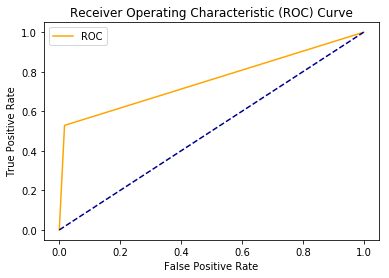

In [44]:
#  ROC for old confusion matrix
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plot_roc_curve(fpr,tpr,1)


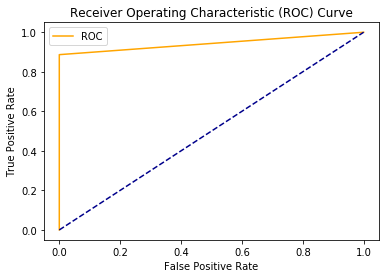

In [46]:
#  ROC for new confusion matrix
fpr1, tpr1, thresholds = roc_curve(y_new, pred_new)

plot_roc_curve(fpr1,tpr1,2)